In [12]:
%matplotlib inline

from itertools import product
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, classification_report, precision_recall_curve
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

WDBC_PATH = "Datasets/WDBC.dat"

INFO_FEATURES  = ["id", "diagnosis"]
FEATURES_NAMES = ["radius", "texture", "perimeter", "area",
                  "smoothness", "compactness", "concavity",
                  "concave_points", "symmetry", "fractal_dimension"]
FEATURE_TYPES  = ["mean", "se", "worst"]  # mean, standard error, max or 'worst'
FEATURES       = ["_".join(p) for p in product(FEATURE_TYPES, FEATURES_NAMES)]

In [13]:
def load_wdbc_data(wdbc_path=WDBC_PATH):
    """ Load data and add headers. """
 
    names = INFO_FEATURES + FEATURES
    
    df = pd.read_csv(wdbc_path, header=0, names=names)
    df['id'] = df['id'].astype(str)  # treat ID as a string, to avoid multiple issues
    
    return df

In [14]:
wdbc = load_wdbc_data()

Let's do some sanity checks.

In [15]:
print("Dataset contains %d data points, %d features. Class counts:" % (wdbc.shape))
print(wdbc["diagnosis"].value_counts())

Dataset contains 568 data points, 32 features. Class counts:
B    357
M    211
Name: diagnosis, dtype: int64


Take a peek at the data.

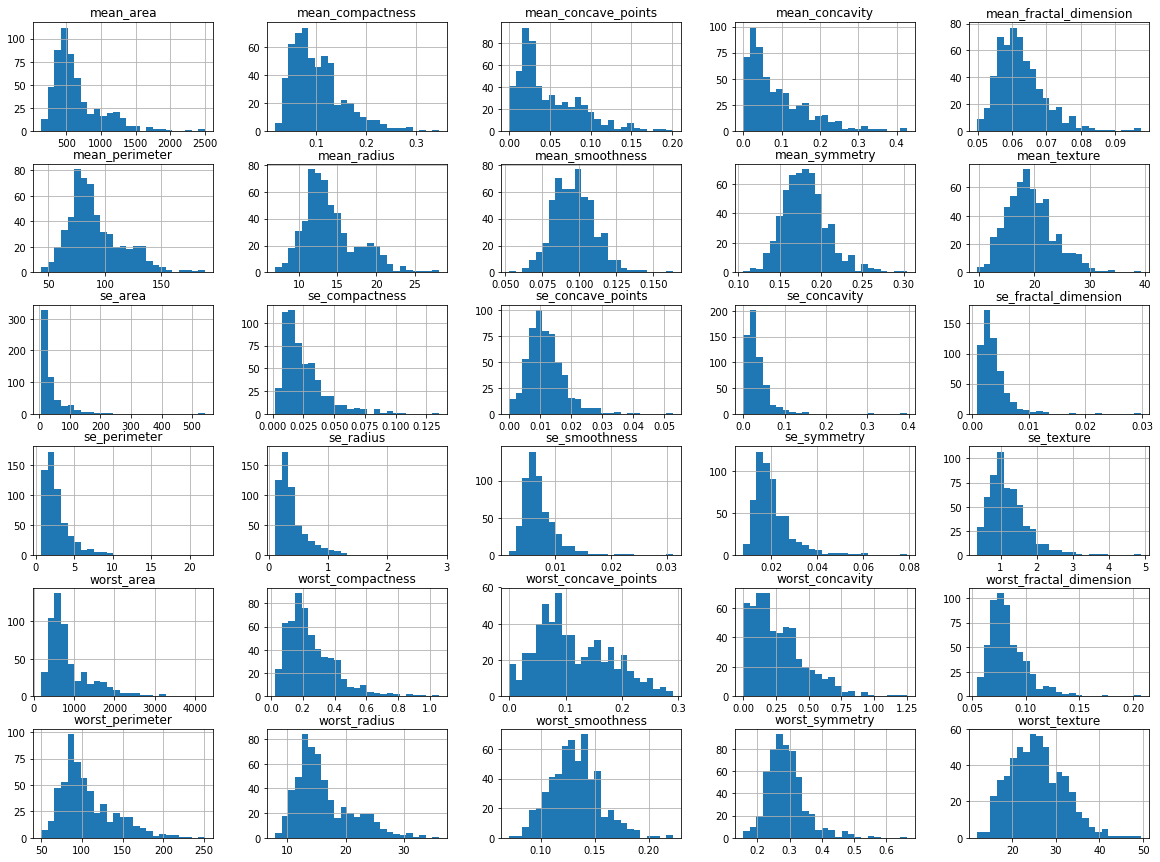

In [273]:
wdbc.hist(bins=25, figsize=(20,15))
plt.show()

Note to self: some features, like mean(area) and mean(concavity), are highly skewed and might need to be log-transformed.

Our dataset is somewhat imbalanced with regards to our class distribution.

In [16]:
wdbc["diagnosis"].value_counts() / wdbc.shape[0]

B    0.628521
M    0.371479
Name: diagnosis, dtype: float64

Create a (final) test set. We will leave this out from all of our parameter and hyperparameter selection procedures.

We need to be a bit careful here. Our dataset is imbalanced with regards to the two diagnoses, so both our training and test sets must reflect the empirical distribution of the diagnoses.

In [17]:
skf = StratifiedKFold(n_splits=5)  # five splits result in a 20% validation set
skf_split = skf.split(np.ones(wdbc.shape[0]), wdbc["diagnosis"])
train, test = next(skf_split)  # we only need the first split

In [18]:
print("Training set has %d data points (%.1f%%)." % (len(train), 100*len(train)/wdbc.shape[0]))
print("Test set has %d data (%.1f%%)." % (len(test), 100*len(test)/wdbc.shape[0]))

Training set has 453 data points (79.8%).
Test set has 115 data (20.2%).


Confirm strata.

In [19]:
print("Training set class distribution:")
print(wdbc.loc[train,"diagnosis"].value_counts() / len(train))
print("Test set class distribution:")
print(wdbc.loc[test,"diagnosis"].value_counts() / len(test))

Training set class distribution:
B    0.629139
M    0.370861
Name: diagnosis, dtype: float64
Test set class distribution:
B    0.626087
M    0.373913
Name: diagnosis, dtype: float64


From now on, I will use only the training set.

In [20]:
wdbc_test = wdbc.loc[test,:]
wdbc = wdbc.loc[train,:]  # just the training set now

The only thing left to do, mostly for convenience, is to separate the predictor variables from the class labels. We can also safely discard the IDs, since we do not need them for this exercise.

In [21]:
wdbc_X = wdbc[FEATURES]
wdbc_y = wdbc["diagnosis"]

wdbc_test_X = wdbc_test[FEATURES]
wdbc_test_y = wdbc_test["diagnosis"]

### Cleaning up the data

Our dataset does not contain any nulls, so we don't have to impute anything.

In [22]:
np.sum(wdbc.isnull().values)

0

All of our predictor variables are numerical and continuous, so there isn't much we can do in the way of encoding. We should, however, encode our classes.

In [23]:
label_encoder = LabelEncoder()
label_encoder.fit(wdbc_y)
print("Encoded class labels: %s" % list(zip(range(2), label_encoder.classes_)))
wdbc_y = label_encoder.transform(wdbc_y)

Encoded class labels: [(0, 'B'), (1, 'M')]


Our positive label, for "malignant" samples, is encoded as "1".

###  Feature scaling

Earlier, I noticed that some features are skewed and span several orders of magnitude. Let's find them and transform them.

In [283]:
skewness = wdbc.skew(numeric_only=True).sort_values(ascending=False)
print(skewness)

se_area                    5.422356
se_perimeter               3.565409
se_radius                  3.200473
se_fractal_dimension       2.950617
se_smoothness              2.514966
se_symmetry                2.327908
se_compactness             1.932807
worst_area                 1.869527
se_texture                 1.653753
mean_area                  1.649266
se_concavity               1.619986
mean_concavity             1.422000
worst_symmetry             1.398651
worst_compactness          1.372005
mean_compactness           1.244476
mean_concave_points        1.230402
mean_fractal_dimension     1.202454
worst_perimeter            1.163706
worst_fractal_dimension    1.161724
worst_radius               1.128051
worst_concavity            1.058889
mean_perimeter             1.029355
mean_radius                0.979346
se_concave_points          0.941245
mean_texture               0.711039
mean_symmetry              0.606123
mean_smoothness            0.551917
worst_texture              0

The standard errors are, not unexpectedly, highly skewed. Most of the "worst" features are also skewed. Let's look at the worst offenders.

Taking the log transform will not work for some of these features because we have zeros in the data. One common approach to deal with this is to use

$$f(x) = \log(1+x)$$

Another common approach is to use a mixture model, treating the zeros as generated from a separate process; that, however, is too involved for this stage of the exercise. So, let's use the "one-plus" log and look at the worst offenders:

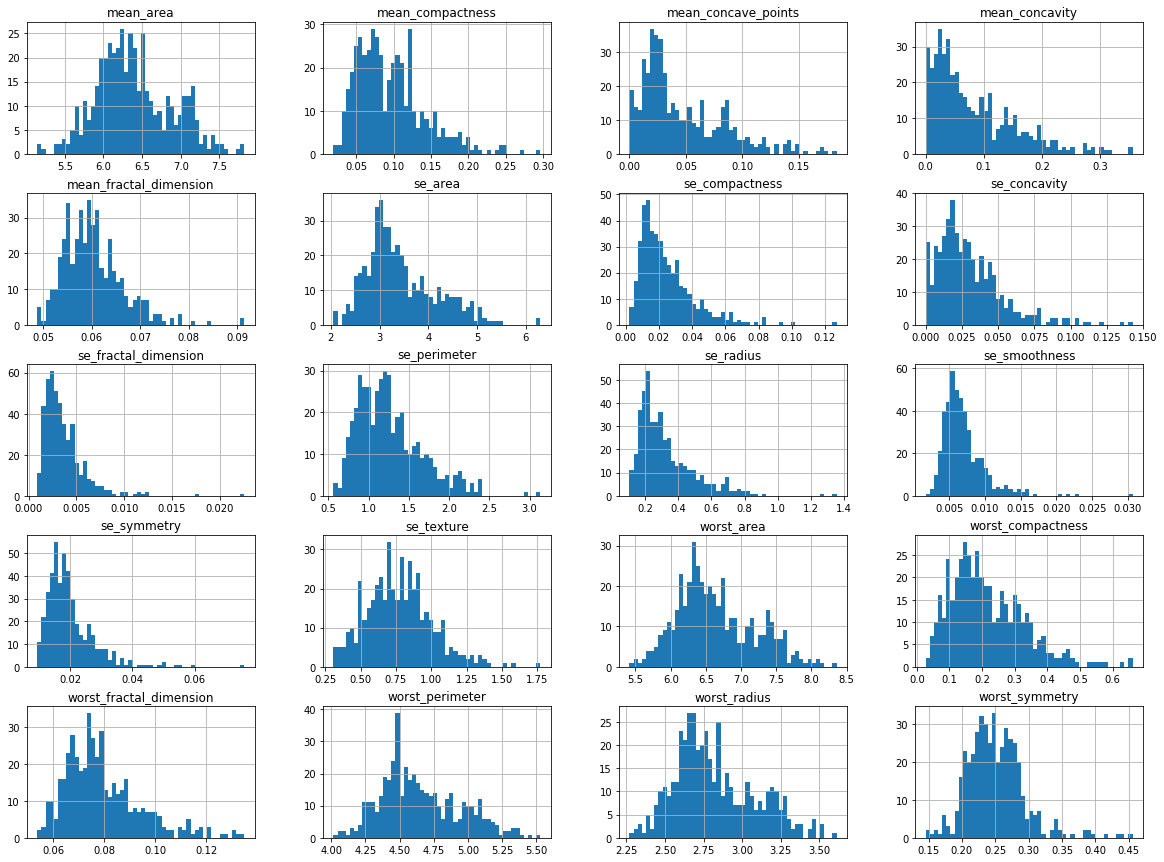

In [284]:
np.log1p(wdbc[skewness.index[0:20]]).hist(bins=50, figsize=(20,15))
plt.show()

The feature distributions look a bit better now. I am unsure about which features to log-transform, so I will make selecting the skewness cut-off point part of hyperparameter training through a custom transformer.

In [24]:
class SkewLogTransformer(BaseEstimator, TransformerMixin):
    """
    Takes log(1+x) for features, x, that have an original
    skewness larger than some threshold. Does not transform others.
    
    Hyperparameters
    ---------------
    skewness_threshold: scalar
    """
    
    def __init__(self, skewness_threshold=1):
        self.skewness_threshold = skewness_threshold
        self._skewness = None
        
    def fit(self, X, y=None):
        self._skewness = stats.skew(X, axis=0)
        self._highskew = self._skewness > self.skewness_threshold
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X[:, self._highskew] = np.log1p(X[:, self._highskew])
        return X

We will follow log transformation with scaling for all features. We would like to scale to zero mean and unit variance, but some of our features have outliers. We will use a RobustScaler, which uses (typically) the interquartile range. While it is possible to tune the quantile range, as a hyperparameter, I will omit this for simplicity.

The feature transformation part of our pipeline is ready.

In [286]:
transform_pipe = Pipeline([
    ("log1p_trans", SkewLogTransformer()),
    ("rob_scaler", RobustScaler())
])

### Feature selection

Our dataset consists of 33 features but only approximately 500 data points. I feel that this is a very large number of features for the amount of data that we have. We should attempt to select fewer, but more predictive, features to avoid overfitting.

Let's do some univariate exploration of our features first. I will compare two commonly-used methods for determining feature relevance: the ANOVA F-values and mutual information between predictors and labels.

In [287]:
f_values, p_values = feature_selection.f_classif(wdbc_X, wdbc_y)
mi_values = feature_selection.mutual_info_classif(wdbc_X, wdbc_y)

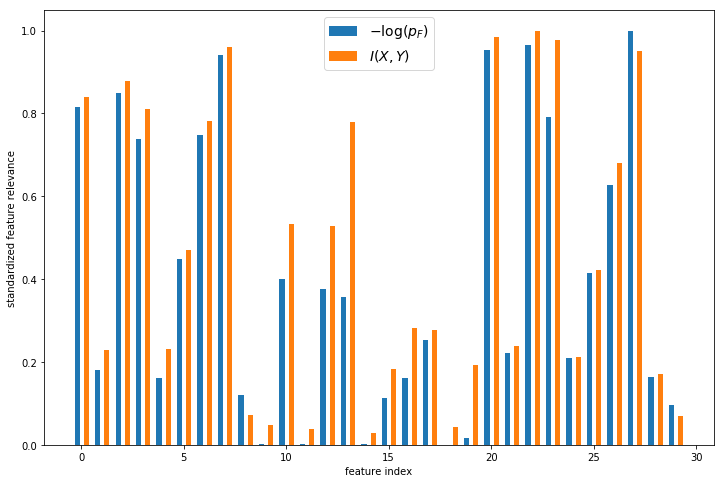

In [288]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
p_standardized = -np.log10(p_values) / (-np.log10(p_values)).max()
mi_standardized = mi_values / mi_values.max()

x_index = np.arange(len(FEATURES))
ax.bar(x_index - 0.20, p_standardized, width=0.25, label="$-\log(p_F)$")
ax.bar(x_index + 0.25, mi_standardized, width=0.25, label="$I(X,Y)$")
ax.set_xlabel("feature index")
ax.set_ylabel("standardized feature relevance")
_ = plt.legend(loc="upper center", prop={"size": 14})

In general, the two methods assign roughly similar importance to each feature (with two or three notable exceptions). The fact that the mutual information criterion assigns the same relative importance as the F-test qualitatively suggests to me that there might be a linear relationship (in the logistic sense) between the highly-informative features and the class label.

In any case, since the two feature selection methods appear to have consensus, I use incorporate the mutual information selector in our feature pipeline. I am partial to the mutual information selector because, when I was working on my [paper](https://www.nature.com/articles/s41467-017-00828-6), scikit-learn did not have out-of-the-box support for mutual information estimation, so I had to instead code it myself from scratch. I even used the same Grassberger paper as the scikit-learn contributors for my non-paremetric entropy estimation method. What a time to be alive.

The most relevant features for univariate classification, in descending order, are:

In [289]:
sorted_mi = mi_standardized.argsort()[::-1]
np.hstack((np.arange(len(FEATURES)).reshape(len(FEATURES),1), np.array(FEATURES)[sorted_mi].reshape(len(FEATURES),1), mi_values[sorted_mi].reshape(len(FEATURES),1)))

array([['0', 'worst_perimeter', '0.4875097488393203'],
       ['1', 'worst_radius', '0.479508689660443'],
       ['2', 'worst_area', '0.47676564501318497'],
       ['3', 'mean_concave_points', '0.4677642223265124'],
       ['4', 'worst_concave_points', '0.46301828203832307'],
       ['5', 'mean_perimeter', '0.42782784001127006'],
       ['6', 'mean_radius', '0.40970903766691924'],
       ['7', 'mean_area', '0.39472922764569973'],
       ['8', 'mean_concavity', '0.3812099201499004'],
       ['9', 'se_area', '0.379665730897109'],
       ['10', 'worst_concavity', '0.3319321316114048'],
       ['11', 'se_radius', '0.2603553146854003'],
       ['12', 'se_perimeter', '0.2571482485289114'],
       ['13', 'mean_compactness', '0.22947056059350235'],
       ['14', 'worst_compactness', '0.20606359903215132'],
       ['15', 'se_concavity', '0.13733019233803212'],
       ['16', 'se_concave_points', '0.13531961748459254'],
       ['17', 'worst_texture', '0.11619691031473711'],
       ['18', 'mean_sm

Not surprisingly, large cells -- particularly those that are irregular -- are more likely to be associated with malignant tumors. Let's check what the distributions of the two classes look like for the best and worst feature.

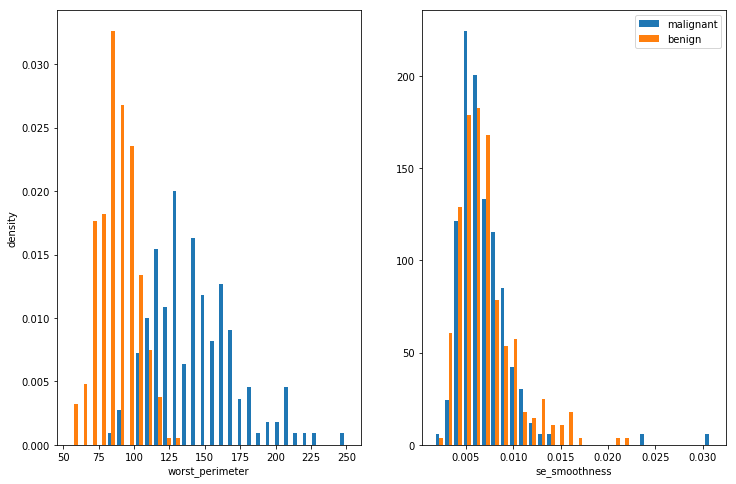

In [292]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))
cax = ax[0].hist([wdbc_X.loc[wdbc_y==1,"worst_perimeter"].values.tolist(), wdbc_X.loc[wdbc_y==0,"worst_perimeter"].values.tolist()], bins=30, density=True)
ax[0].set_xlabel("worst_perimeter")
ax[0].set_ylabel("density")
cax = ax[1].hist([wdbc_X.loc[wdbc_y==1,"se_smoothness"].values.tolist(), wdbc_X.loc[wdbc_y==0,"se_smoothness"].values.tolist()], bins=30, density=True, label=["malignant", "benign"])
ax[1].set_xlabel("se_smoothness")
_ = ax[1].legend()

The nice separation on the left-hand side bodes well for our classification task. We will probably not use the noise features in our predictor.

#### Feature correlation

The nature of our data (means, standard errors, and maximum) implies that we will have strong correlations between our features. Features like "area", "perimeter", and "radius" should also be correlated. Let's confirm this by visualizing the correlation matrix.

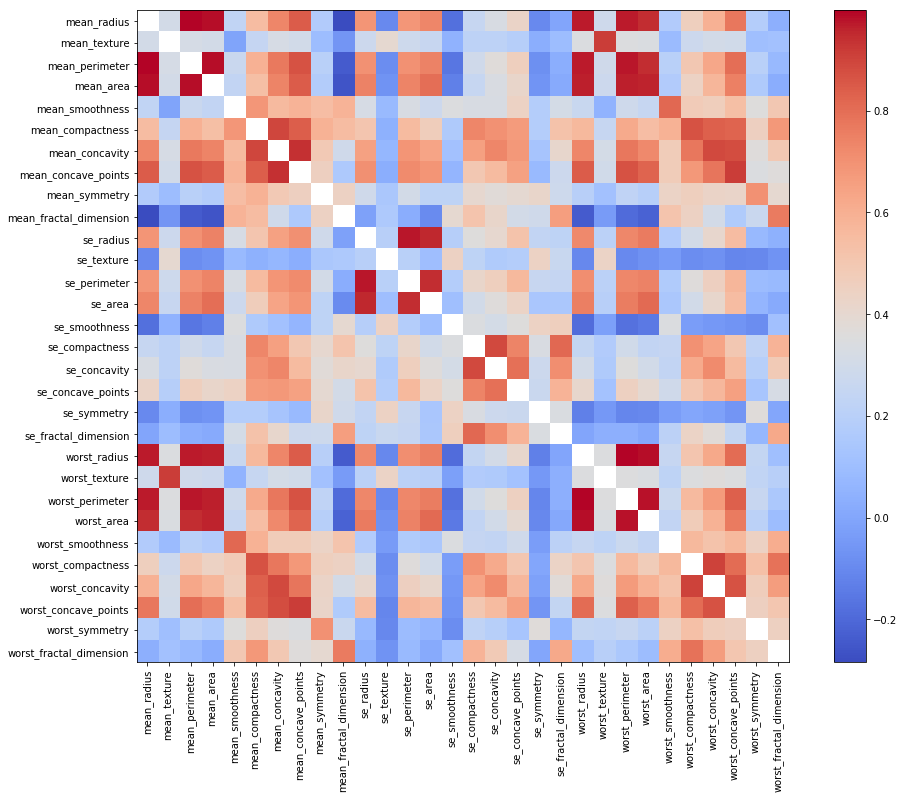

In [26]:
C = np.corrcoef(wdbc_X.T)
# Turn off the main diagonals
for i in range(C.shape[0]):
    C[i,i] = None
    
fig, ax = plt.subplots(1,1, figsize=(16,12))
cax = ax.imshow(C, interpolation=None, cmap=plt.get_cmap("coolwarm"))

ax.set_xticks(np.arange(C.shape[0]))
ax.set_xticklabels(FEATURES)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.arange(C.shape[0]))
ax.set_yticklabels(FEATURES)

_ = fig.colorbar(cax)

Correlated features usually degrade classifier performance, since they lead to overfitting. We will write a custom feature selector for our pipeline to drop features that are highly correlated with at least one other feature.

In [295]:
class CorrelatedDropper(BaseEstimator, TransformerMixin):
    """
    Drops highly correlated features.
    
    Working with the upper triangular part of the correlation matrix,
    drops a feature (row) that is highly correlated with at least
    one other feature (column).
    
    Hyperparameters
    ---------------
    correlation_threshold: scalar in [0, 1]
    """
    
    def __init__(self, correlation_threshold=0.95):
        self.correlation_threshold = correlation_threshold
        self._corr_mat = None
        
    def fit(self, X, y=None):
        self._corr_mat = np.abs(np.corrcoef(X.T))
        # Turn off the main diagonals
        for i in range(self._corr_mat.shape[0]):
            self._corr_mat[i, i] = 0.
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        # Find features to keep.
        rows_to_keep = [row for row in range(self._corr_mat.shape[0]) if all(np.triu(self._corr_mat)[row, :] < self.correlation_threshold)]
        
        return X[:, rows_to_keep]

Our feature selection pipeline is ready. We have two hyperparameters to tune: the number of best features, according to (univariate) mutual information to keep, and the correlation threshold below which we drop correlated features.

In [330]:
selection_pipe = Pipeline([
    ("corr_dropper", CorrelatedDropper()),
    ("univariate_selector", SelectPercentile(score_func=mutual_info_classif))
])

I think it makes more sense to drop correlated features first, and then select the best features in some top percentile, so I have arranged the pipeline in that manner. 

We are now ready for the classification component of our pipeline.

### Classification

I will compare the performance of three classification methods in this exercise: a logistic regression, a SVM classifier with Gaussian kernel, and an ensemble of decision trees classifier. Let's create full pipelines for each of these classifiers. We will also specify the hyperparameters to optimize for each.

In [785]:
logistic_pipe = Pipeline(
    steps = transform_pipe.steps + selection_pipe.steps +
            [("logistic", LogisticRegression(solver="liblinear"))]
)

svm_pipe = Pipeline(
    steps = transform_pipe.steps + selection_pipe.steps +
            [("svm", SVC(kernel="rbf", class_weight="balanced", gamma="scale", 
                         probability=True))]
)

forest_pipe = Pipeline(
    steps = transform_pipe.steps + selection_pipe.steps +
    [("forest", RandomForestClassifier(class_weight="balanced_subsample", n_jobs=-1))]
)


# Hyperparameters for the common pipeline components.
common_hyperparams = {
    "log1p_trans__skewness_threshold": stats.uniform(0, 6),
    "corr_dropper__correlation_threshold": stats.uniform(0.75, 0.25),
    "univariate_selector__percentile": stats.uniform(1, 99)
}

# Hyperparameters to learn for logistic regression.
_logistic_hyperparams = {
    "logistic__C": stats.expon(1e-2),
    "logistic__penalty": ["l1", "l2"]
}

# Hyperparameters to learn for SVM.
_svm_hyperparams = {
    "svm__C": stats.expon(1e-2),
}

_forest_hyperparams = {
    "forest__n_estimators": np.arange(50,500, 50),
    "forest__max_depth": np.arange(1, 33),
    "forest__max_features": stats.uniform(),
    "forest__min_samples_split": stats.uniform()
}

logistic_hyperparams = {**common_hyperparams, **_logistic_hyperparams}
svm_hyperparams = {**common_hyperparams, **_svm_hyperparams}
forest_hyperparams = {**common_hyperparams, **_forest_hyperparams}

We will perform a randomized, cross-validated, search over the above hyperparameter distributions to find the best values. We will use several scoring metrics for evaluating hyperparameter performance: precision and recall, the F1 score, which does a decent job with imbalanced datasets, as well as the area under of the ROC curve, which we might want to look at later when tuning the cutoff of our classifier. Finally, as before, we will use a stratified nested cross-validation scheme to evaluate our pipeline at every hyperparameter set.

In [810]:
scoring = ["precision", "recall", "f1", "roc_auc"]

N_ITER = 100

logistic_grid = RandomizedSearchCV(logistic_pipe, logistic_hyperparams, 
                                   scoring=scoring,
                                   cv=StratifiedKFold(n_splits=5),
                                   refit="f1",
                                   iid=False,
                                   return_train_score=True,
                                   n_iter=N_ITER,
                                   n_jobs=-1)
logistic_grid._name = "logistic"

svm_grid = RandomizedSearchCV(svm_pipe, svm_hyperparams, 
                              scoring=scoring,
                              cv=StratifiedKFold(n_splits=5),
                              refit="f1",
                              iid=False,
                              return_train_score=True,
                              n_iter=N_ITER,
                              n_jobs=-1)
svm_grid._name = "svm"

forest_grid = RandomizedSearchCV(forest_pipe, forest_hyperparams, 
                              scoring=scoring,
                              cv=StratifiedKFold(n_splits=5),
                              refit="f1",
                              iid=False,
                              return_train_score=True,
                              n_iter=N_ITER,
                              n_jobs=-1)
forest_grid._name = "forest"

In [811]:
for grid in (logistic_grid, svm_grid, forest_grid):
    print("[*] Searching hyperparameter grid for %s classifier." % grid._name)
    grid.fit(wdbc_X, wdbc_y)
    print("[.] Best score = %.3f." % grid.best_score_)
    print("[.] Best params = %s.\n" % grid.best_params_)

[*] Searching hyperparameter grid for logistic classifier.
[.] Best score = 0.978.
[.] Best params = {'corr_dropper__correlation_threshold': 0.9338667955404746, 'log1p_trans__skewness_threshold': 5.603952408448356, 'logistic__C': 0.5862134470105761, 'logistic__penalty': 'l2', 'univariate_selector__percentile': 96.06949850148641}.

[*] Searching hyperparameter grid for svm classifier.
[.] Best score = 0.979.
[.] Best params = {'corr_dropper__correlation_threshold': 0.9633687796914314, 'log1p_trans__skewness_threshold': 1.3134955837783928, 'svm__C': 1.014177424694963, 'univariate_selector__percentile': 98.60152277375511}.

[*] Searching hyperparameter grid for forest classifier.
[.] Best score = 0.950.
[.] Best params = {'corr_dropper__correlation_threshold': 0.8966161793706676, 'forest__max_depth': 4, 'forest__max_features': 0.4846559226828545, 'forest__min_samples_split': 0.030007386860453455, 'forest__n_estimators': 150, 'log1p_trans__skewness_threshold': 2.785865105960092, 'univariat

The various evaluation metrics, sorted in order of decreasing F1 performance on the test set:

In [812]:
logistic_cv = pd.DataFrame(logistic_grid.cv_results_)
svm_cv = pd.DataFrame(svm_grid.cv_results_)
forest_cv = pd.DataFrame(forest_grid.cv_results_)

For logistic regression:

In [871]:
logistic_cv[[ "mean_" + "_".join(m) for m in product(("test",), scoring) ]].sort_values(by="mean_test_f1", ascending=False).head(10)

,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
80,1.000000,0.958824,0.978454,0.995666
99,0.971905,0.982353,0.976639,0.994731
15,0.993750,0.958645,0.975756,0.993783
81,0.993939,0.958645,0.975663,0.994915
40,1.000000,0.952763,0.975377,0.994912
17,1.000000,0.952763,0.975377,0.994499
84,0.976807,0.970410,0.973303,0.994102
87,0.981996,0.964706,0.973044,0.994321
60,0.988235,0.958645,0.972863,0.994502
88,0.988057,0.958645,0.972766,0.996250


For SVM:

In [872]:
svm_cv[[ "mean_" + "_".join(m) for m in product(("test",), scoring) ]].sort_values(by="mean_test_f1", ascending=False).head(10)

,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
79,0.994118,0.964706,0.978833,0.996072
62,0.971082,0.976471,0.973482,0.996904
45,0.994118,0.952763,0.972480,0.994696
29,0.976628,0.964706,0.970049,0.995975
93,0.993939,0.946881,0.969224,0.996141
82,0.988057,0.946881,0.966333,0.994186
65,0.965508,0.964706,0.964251,0.994105
10,0.970999,0.958824,0.963977,0.994305
64,0.976975,0.952763,0.963891,0.995634
71,0.975379,0.952763,0.963817,0.991097


For RandomForest:

In [873]:
svm_cv[[ "mean_" + "_".join(m) for m in product(("test",), scoring) ]].sort_values(by="mean_test_f1", ascending=False).head(10)

,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
79,0.994118,0.964706,0.978833,0.996072
62,0.971082,0.976471,0.973482,0.996904
45,0.994118,0.952763,0.972480,0.994696
29,0.976628,0.964706,0.970049,0.995975
93,0.993939,0.946881,0.969224,0.996141
82,0.988057,0.946881,0.966333,0.994186
65,0.965508,0.964706,0.964251,0.994105
10,0.970999,0.958824,0.963977,0.994305
64,0.976975,0.952763,0.963891,0.995634
71,0.975379,0.952763,0.963817,0.991097


Generally, the hyperparameters that optimize the F1 score offer a good compromise between precision and recall. However, in a setting like cancer detection, it might be better to maximize recall (fraction of malignant cases detected, in this case) and less important to minimize false positives. I think this particularly true for early screening tests, where a positive result on an initial test can be followed up by a more conclusive follow-up test.

Let's look at the precision--recall tradeoff curve for our classifiers.

In [816]:
precision_logistic, recall_logistic, thresholds_logistic = precision_recall_curve(wdbc_y, logistic_grid.predict_proba(wdbc_X)[:,1])
precision_svm, recall_svm, thresholds_svm = precision_recall_curve(wdbc_y, svm_grid.predict_proba(wdbc_X)[:,1])
precision_forest, recall_forest, thresholds_forest = precision_recall_curve(wdbc_y, forest_grid.predict_proba(wdbc_X)[:,1])

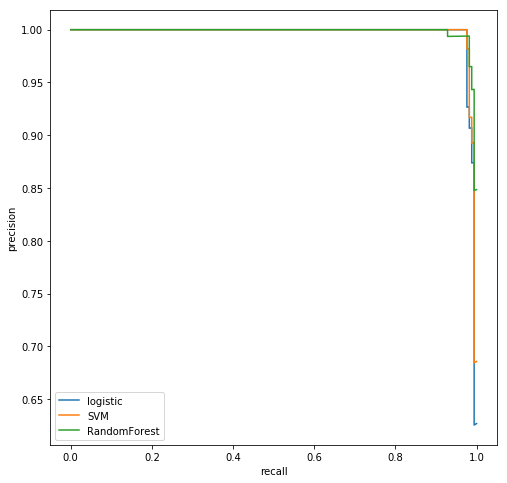

In [825]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(recall_logistic, precision_logistic, label="logistic")
ax.plot(recall_svm, precision_svm, label="SVM")
ax.plot(recall_forest, precision_forest, label="RandomForest")
ax.set_xlabel("recall")
ax.set_ylabel("precision")
_ = plt.legend()

The classifiers perform comparably on the training set.

To make the classifier retrieve all malignant cases (i.e. recall = 1) we have to sacrifice precision. We do this by changing the probability threshold over which a sample is classified as malignant. By default, this is 1/2. Here is what the results look like as we vary the decision threshold.

In [826]:
def predict_at_threshold(X, classifier, threshold=0.5):
    return (classifier.predict_proba(X)[:, 1] > threshold).astype(int)

def threshold_vs_metric(X, y_true, classifier, metric):
    
    thresholds = np.linspace(0, 1, 100)
    scores = np.zeros_like(thresholds)
    
    for i, t in enumerate(thresholds):
        scores[i] = metric(y_true, predict_at_threshold(X, classifier, t))
        
    return thresholds, scores

In [827]:
# This isn't the prettiest code.
thresholds, logistic_recall = threshold_vs_metric(wdbc_X, wdbc_y, logistic_grid, metrics.recall_score)
thresholds, logistic_precision = threshold_vs_metric(wdbc_X, wdbc_y, logistic_grid, metrics.precision_score)

thresholds, svm_recall = threshold_vs_metric(wdbc_X, wdbc_y, svm_grid, metrics.recall_score)
thresholds, svm_precision = threshold_vs_metric(wdbc_X, wdbc_y, svm_grid, metrics.precision_score)

thresholds, forest_recall = threshold_vs_metric(wdbc_X, wdbc_y, forest_grid, metrics.recall_score)
thresholds, forest_precision = threshold_vs_metric(wdbc_X, wdbc_y, forest_grid, metrics.precision_score)

/home/christos/Documents/ML/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/christos/Documents/ML/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/christos/Documents/ML/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


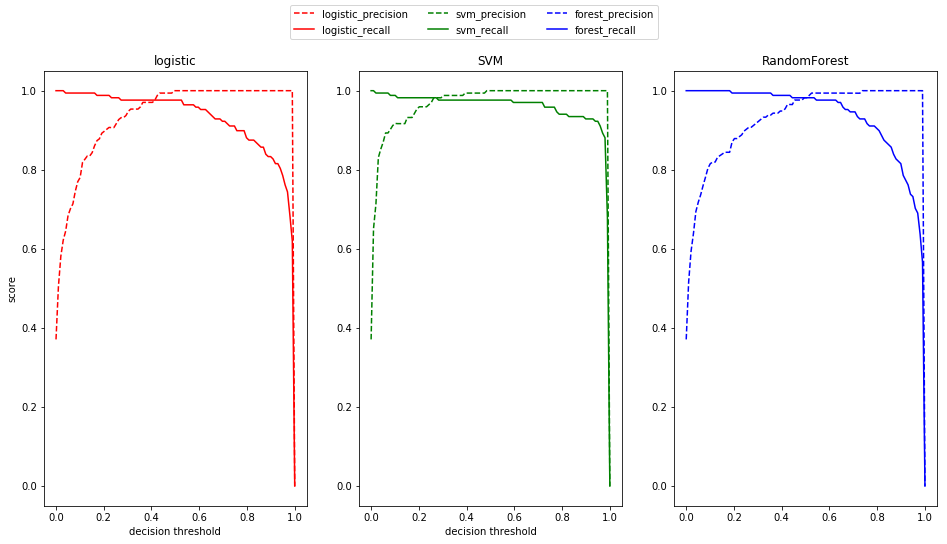

In [830]:
fig, ax = plt.subplots(1, 3, figsize=(16,8))

ax[0].plot(thresholds, logistic_precision, 'r--', label='logistic_precision')
ax[0].plot(thresholds, logistic_recall, 'r', label='logistic_recall')
ax[0].set_title("logistic")

ax[1].plot(thresholds, svm_precision, 'g--', label='svm_precision')
ax[1].plot(thresholds, svm_recall, 'g', label='svm_recall')
ax[1].set_title("SVM")

ax[2].plot(thresholds, forest_precision, 'b--', label='forest_precision')
ax[2].plot(thresholds, forest_recall, 'b', label='forest_recall')
ax[2].set_title("RandomForest")

for i in range(2):
    ax[i].set_xlabel("decision threshold")
    
ax[0].set_ylabel("score")
fig.legend(loc="upper center", ncol=3)

The ensemble classifier appears to be a better choice if we want to retrieve all malignant cases while minimizing the false positive rate. For this classifier, we would have to set the decision threshold to:

In [845]:
recall_thresholds = {}
for r in (1., 0.99, 0.95):
    threshold_argmax = np.max(np.where(forest_recall>=r))
    recall_thresholds[r] = thresholds[threshold_argmax]
    print("For recall = %.2f: precision = %.2f with threshold = %.2f." % 
          (r, forest_precision[threshold_argmax], recall_thresholds[r]))

For recall = 1.00: precision = 0.84 with threshold = 0.18.
For recall = 0.99: precision = 0.94 with threshold = 0.35.
For recall = 0.95: precision = 0.99 with threshold = 0.68.


Selecting an appropriate threshold depends on how our diagnostic test is meant to be used. We will see how the three above decision thresholds perform against the test set.

#### Test set performance

We are finally ready to evaluate the performance of our best classifier against the test set that we had originally left out of training.

In [844]:
y_test_pred_proba = forest_grid.predict_proba(wdbc_test_X)

In [866]:
for recall, threshold in recall_thresholds.items():
    print("Test set confusion matrix with decision threshold = %.2f (training set recall= %.2f):" %
          (threshold, recall))
    print(confusion_matrix(le.transform(wdbc_test_y), (y_test_pred_proba[:, 1] > threshold).astype(int)))
    print("")

Test set confusion matrix with decision threshold = 0.18 (training set recall= 1.00):
[[63  9]
 [ 1 42]]

Test set confusion matrix with decision threshold = 0.35 (training set recall= 0.99):
[[64  8]
 [ 3 40]]

Test set confusion matrix with decision threshold = 0.68 (training set recall= 0.95):
[[71  1]
 [ 7 36]]



Our classifier misclassified one malignant case when we were being the most conservative (recall = 0.976), and seven when we were being the least conservative (recall = 0.837). The precision was 0.875 and 0.986 respectively.

These numbers are in line with the precision/recall values for our training set, which suggests that our classifier is not overfitting (very much) during training.